# Imports

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.examples.tutorials.mnist import input_data

# Configuration of Neural Network

In [3]:
# convolutional layer 1
filter_size1 = 5
num_filters1 = 16

# convolutional layter 2
filter_size2 = 5
num_filters2 = 36

# full-connected layer
fc_size = 128

# Load Data

In [4]:
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz


Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [5]:
print("size of:")
print("- training-set:\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

size of:
- training-set:	55000
- Test-set:		10000
- Validation-set:	5000


In [6]:
data.test.cls = np.argmax(data.test.labels, axis=1)

## Data Dimensions

In [7]:
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_channels = 1
num_classes = 10

In [10]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # create figure with 3x3 sub-plots
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    plt.clf()
    for i, ax in enumerate(axes.flat):
        # plot the image
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        # show the true and predicted classes
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel)
        # remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

## Plot a few images to see if data is correct

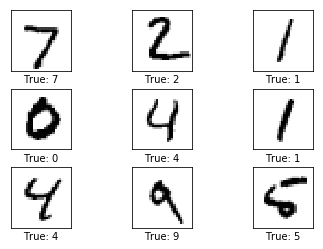

In [11]:
# get the first set images from the test-set
images = data.test.images[0:9]
# get tht true classes for those images
cls_true = data.test.cls[0:9]
# plot the images and labels using the lot_images function
plot_images(images=images, cls_true=cls_true)

# Tensorflow Graph

## helper-functions for creating new variables
create graph Variables in Tensorflow and initialize them

In [12]:
# define weight variables and initialize it
def new_weights(shape):
    return tf.Variabfle(tf.truncated_normal(shape, stddev=0.05))

# define biases variables and initialize it
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

## helper-function for creating a new Convolutional Layer
The function creates a new convolutional layer in the computational graph for Tensorflow. Nothing is actually calculated here, we are just adding the mathmatical formulas to the Tensorflow graph

In [18]:
def new_conv_layer(input,   # the previous layer
                   num_input_channels, # Num. channels in prev. layer
                   filter_size, # width and height of each filter
                   num_filters, # number of filters
                   use_pooling=True): # use 2x2 max-pooling
    # shape of filter-weithts for the convolution
    # this format is determined by the Tensorflow API, that is 
    # [filter_height, filter_width, in_channels, out_channels]
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    
    # create new weights and initialize it, also known as filters with the given shape
    weights = new_weights(shape=shape)
    
    # create new biases, one for each filter
    biases = new_biases(length=num_filters)
    
    # create the TensorFlow operation for convolution
    # strides: A list of `ints`. 1-D tensor of length 4.
    # note that the strides are set to 1 in all dimensions
    # the first and last stride must always be 1
    # because the first is for the image-number and the last
    # is for input-channel. But e.g. strides=[1,2,2,1] would 
    # mean [img_num, x-axis_stride, y-axis_stride, input_channel]
    # padding='SAME': means the input image is padded with zeroes 
    # so the size of the output is the same
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    
    # add the biases to the results of convolution. A bias-value is added to each filter-channel
    layer += biases
    
    # Use pooling to down-sampling the image resolution
    # this is 2x2 max-pooling, which means that we consider 2x2 windows and select the
    # largest value in each window. Then we move 2 pixels for the next window
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
    
    # Rectified Linear Unit(ReLU)
    # It calculates max(x,0) for each input pixel x.
    # since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first
    layer = tf.nn.relu(layer)
    
    # return both the resulting layer and the filter-weights
    # because we will plot the weights lagter
    return layer, weights

## helper-function for flattening a layer
A convolutional layer produces an output tensor with 4 dimensions. we will add fully-connected layers after the convolutional layers, so we need to reduce the 4-D tensor to 2-D which can be used as input to the fully-connected layer.

In [31]:
def flatten_layer(layer):
    # get the shape of input layer
    layer_shape = layer.get_shape()
    
    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]
    
    # the number of features is: img_height * img_width * img_channels
    # we can use a function from TensorFlow to calculate this
    num_features = layer_shape[1:4].num_elements()
    
    # reshape the layer to [num_images, num_features]
    # -1 means the size in that dimension is calculated
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    # return both the flattened layer and the number of features
    return layer_flat, num_features

## helper-function for creating a new Fully-connected layer
<p>This function creates a new fully-connected layer in the computational graph for TensorFlow. Nothing is actually calculated here. We are just adding the mathmatical formulars to the TensorFlow graph.
</p>
It is assumed that the input is a 2-D tensor of shape [num_images, num_inputs]. The output is a 2-D tensor of shape [num_images, num_outputs]

In [42]:
def new_fc_layer(input, # the previous layer
                 num_inputs, # num of inputs from prev. layer
                 num_outputs, # num of outputs
                 use_relu=True): # use Rectified Linear Unit (ReLU)?
    
    # create new weights and biases and initialize them 
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    
    # calculate the layer as the matrix multiplication of the input and weights, 
    # and then add the bias-values
    layer = tf.matmul(input, weights) + biases
    
    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)
        
    return layer

## placeholder variables
placeholder variables serve as the input to the TensorFlow computational graph that we may change each time we excute the graph. We call this the placeholder variables.

In [33]:
# [None, img_size_flat]: None means the tensor may hold arbitrary number of images with
# each image being a vector of length img_size_flat
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

# Since the convolutional layers expect x to be encoded as a 4-D tensor so we have to reshape it instead
# [num_images, img_height, img_width, num_channels].
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

# placeholder variable for the true labels associated with the images that were
# input in the placeholder variable x
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
# placeholder variable for true class-number
y_true_cls = tf.argmax(y_true, axis=1)

## convolutional layer 1
create the first convolutional layer. It takes x_image as input and creates num_filters1 different filters. each have width and height eqaul to filter_size1. Finally, we utilize down-sampling and 2x2 max-pooling.

In [34]:
layer_conv1, weights_conv1 = new_conv_layer(input=x_image,
                                            num_input_channels=num_channels,
                                            filter_size=filter_size1,
                                            num_filters=num_filters1,
                                            use_pooling=True)

In [35]:
# check the shape of tensor that is (?,14,14,16) which means that
# the output is an arbitrary number of images (signed by ?)
layer_conv1

<tf.Tensor 'Relu_4:0' shape=(?, 14, 14, 16) dtype=float32>

## Convolutional layer2
create the second convolutional layer, which takes as input the output from the first convolutional layer. The numebr of input channels corresponds to the number of filters in the first convolutional layer

In [36]:
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1,
                                            num_input_channels=num_filters1,
                                            filter_size=filter_size2,
                                            num_filters=num_filters2,
                                            use_pooling=True)

In [37]:
# check the output shape of the convolutional layer2
layer_conv2

<tf.Tensor 'Relu_5:0' shape=(?, 7, 7, 36) dtype=float32>

## Flatten Layer which is prepare for the fully-connected layer
The convolutional layers output 4-D tensors. We now wish to use these as input in a fully-connected network, which requires for the tensors to be reshaped or flattened to 2-D tensors.

In [39]:
layer_flat, num_features = flatten_layer(layer_conv2)

check that the tensor now have shape (?, 1764) which means there's an arbitrary number of images which have been flattened to vectors of length 1764 each. Note that 1764 = 7x7x36

In [40]:
layer_flat

<tf.Tensor 'Reshape_4:0' shape=(?, 1764) dtype=float32>

In [41]:
num_features

1764

## Fully-connected layer 1
add a fully-connected layer to the network. The input is the flattened layer from the previous convolution. The numeber of neurons or nodes in the fully-connected connected layer is fc_size. ReLU is used so that we can learn non-linear relation.

In [45]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features, # for one image, there will be num_features as input
                         num_outputs=fc_size,
                         use_relu=True)

In [47]:
# output the fully-connected layer shape
layer_fc1

<tf.Tensor 'Relu_8:0' shape=(?, 128) dtype=float32>

## fully-connected layer 2
add fully-connected layer that outputs vectors of length 10 for determining which of the 10 classes the input image belongs to. Note that ReLU is not used in this layer

In [48]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [49]:
layer_fc2

<tf.Tensor 'add_10:0' shape=(?, 10) dtype=float32>

## predicted classes
The second fully-connected layer estimates how likely that the input image belongs to each of the 10 classes. However, this is very diffcult to interprete because the numbers may be very small or large, so we want to normalize them so that each elements is limited between 0 and 1. And the 10 elements sum to 1. This is calculated using the so-called softmax function and the result is stored in y_pred.

In [50]:
y_pred = tf.nn.softmax(layer_fc2)

In [51]:
# the class-number is the index of the largest element
y_pred_cls = tf.argmax(y_pred, axis=1)

## cost-function to be optimized
<p>The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if predicted output of the model exactly matches the desired output then the cross-entropy equals to 0. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to 0 as possible by changing the variables of the network layers.</p>
Note that the build-in function to compute cross-entropy in the TensorFlow calculates the softmax internally so we must use the output of layer_fc2 directly rather than y_pred which has already has the softmax applied.

In [52]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)

In [53]:
cost = tf.reduce_mean(cross_entropy)

## optimization method
<p>Now we have a cost measure that must be minimized, we can create an optimizer. In this case it is the AdamOptimizer which is an advanced form of Gradient Descent</p>
Note that optimization is not performed at this point, nothing is calculated at all, we just add the optimizer-obeject to the TensorFlow graph for later excution

In [61]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

## performance measures

In [62]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [64]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# TensorFlow Run

## create TensorFlow session
Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [65]:
session = tf.Session()

## initialize variables
The variables for weights and biases must be initialized

In [66]:
session.run(tf.global_variables_initializer())